In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option("display.max_columns", None)


## Features
* Age
* sex
* income_per_annum
* occupation
* #trades
* logins
* number of logins in last year
* years with iifl
* days since lasy login
* online%
* FAO segment
* dp_holding
* ledger balance
* Z20
* brokerage Total
* app_status
* E2 channel
* iskarvy

In [33]:
df_client = pd.read_csv("../data/df_client_equity.csv")
df_client_master = pd.read_csv("../data/dw_mst_client.csv")
df_seg = pd.read_csv("../data/client_segmentation_strategy.csv")
df_app_clients = pd.read_csv("../data/app_clients.csv")

df_FAO = pd.read_csv("../data/FAO_clients.csv")
df_ledger = pd.read_csv("../data/ledger_balance.csv")
df_dm = pd.read_csv("../data/iifl_Clients_DM.csv")
df_etf = pd.read_csv("../data/ETF_placed_data.csv")
df_test = pd.read_csv("../data/client_demographics_data.csv")

df_tt_logins = pd.read_csv("../data/Client_TT_logins.csv")



In [13]:
df_client["cm_cd"] = df_client["cm_cd"].astype(str).str.split(".").str[0]
df_etf["ClientCode"] = df_etf["ClientCode"].astype(str).str.split(".").str[0]
df_etf["ETF"] = [1]*len(df_etf)

##### adding demographics and ETF columns

In [14]:
df_model = pd.merge(df_etf, df_client,
                    left_on = "ClientCode", 
                    right_on = "cm_cd", a
                    how = "right")[["cm_cd", "cm_sex", "cm_dob", 
                                    "IncomePA",
                                    "Last_MobileLoginDate","E2Channel", "IsKarvy", "ETF"]]

In [15]:
df_model["ETF"] = df_model["ETF"].fillna(0)

In [18]:
# adding age column
df_model["cm_dob"] = df_model["cm_dob"].astype(str).str.split(".").str[0] 
age = df_model["cm_dob"].astype(str).apply(calculate_age)
df_model["cm_age"] = age
del df_model['cm_dob']

In [21]:
# adding days since actvation column
now = datetime.now()
today = str(now.year) + '{:02d}'.format(now.month) + '{:02d}'.format(now.day)
df_model["Last_MobileLoginDate"] = df_model["Last_MobileLoginDate"].astype(str).str.split(".").str[0] 
df_model["days_since_last_login"] = df_model.apply(lambda x: calculate_days(x['Last_MobileLoginDate'], today), axis = 1)
del df_model["Last_MobileLoginDate"]

In [22]:
df_model

cm_cd cm_sex IncomePA       E2Channel  IsKarvy  ETF  cm_age  \
0        RAPT1001      M    5_10L      Franchisee        0  1.0    34.0   
1        SIQBAL22      M    5_10L          Premia        0  1.0    32.0   
2        OPA10002      M    5_10L      Franchisee        0  1.0    26.0   
3        52093616      M     1_5L             CAT        0  1.0    46.0   
4        SIG10103      M    5_10L      Franchisee        0  1.0    36.0   
...           ...    ...      ...             ...      ...  ...     ...   
2287213  AJPATEL8      M      NaN           Banca        0  0.0    46.0   
2287214  AJPATEL9      M      NaN          Premia        0  0.0    40.0   
2287215  AJPATH60      M     1_5L  GL Investments        0  0.0    48.0   
2287216  AJPATHAK      M      NaN             CAT        0  0.0    66.0   
2287217  AJPATID7      M     1_5L             CAT        0  0.0    34.0   

         days_since_last_login  
0                          NaN  
1                         33.0  
2                         33.0  
3                         27.0  
4                         27.0  
...                        ...  
2287213                    NaN  
2287214                    NaN  
2287215                    NaN  
2287216                    NaN  
2287217                  648.0  

[2287218 rows x 8 columns]

##### add FAO segment activation

In [23]:
df_FAO["FAO"] = [1]*len(df_FAO)
df_model = pd.merge(df_FAO, df_model,
                    left_on = "LoginID", 
                    right_on = "cm_cd", 
                    how = "right")[list(df_model.columns) + ["FAO"]]

In [24]:
df_model["FAO"] = df_model["FAO"].fillna(0)

##### add app status activatio

In [25]:
df_app_clients["app_status"] = [1]*len(df_app_clients)
df_model = pd.merge(df_app_clients, df_model,
                    left_on = "ClientCode", 
                    right_on = "cm_cd", 
                    how = "right")[list(df_model.columns) + ["app_status"]]

In [26]:
df_model["app_status"] = df_model["app_status"].fillna(0)

In [27]:
df_model.head()

cm_cd cm_sex IncomePA   E2Channel  IsKarvy  ETF  cm_age  \
0  DOLLAR56      M     1_5L  Franchisee        0  0.0    38.0   
1  SINKUM67      M      NaN         CAL        0  0.0    54.0   
2  AAYUSHI4      M      NaN  Franchisee        0  0.0    49.0   
3  KULW1969      F     1_5L  Franchisee        0  0.0    52.0   
4  BHASHDFC      M     <=1L      Premia        0  0.0    32.0   

   days_since_last_login  FAO  app_status  
0                   89.0  0.0         1.0  
1                 2160.0  1.0         1.0  
2                  648.0  1.0         1.0  
3                  697.0  0.0         1.0  
4                   28.0  0.0         1.0

#### add ledger balance

In [28]:
df_model = pd.merge(df_ledger, df_model,
                    left_on = "LoginID", 
                    right_on = "cm_cd", 
                    how = "inner")[list(df_model.columns) + ["LB"]]

In [29]:
df_model["ETF"].value_counts()

0.0    1522796
1.0      47892
Name: ETF, dtype: int64

#### add trade history

In [35]:
df_test = pd.merge(df_model, df_dm,
                    left_on = "cm_cd", 
                    right_on = "Client", 
                    how = "inner")[list(df_model.columns) + ["6 Mnths Trades#", "6 Mnths TTLogins", "6 Mnths Online%"]]

##### adding trading history data

In [36]:
df_trade_history = pd.read_csv("../data/trade_history_last_year.csv")

In [37]:
df_trade_history[df_trade_history["Client_Code"] == "79380282"]

Client_Code  online%  Ttweb%  #trades  #TT_logins  #mobile_logins
80882    79380282      0.0     0.0        2           0               0

In [38]:
df_trade_history.head()

Client_Code   online%  Ttweb%  #trades  #TT_logins  #mobile_logins
0    NAGESHSV    900.00     0.0       13           0              13
1    PANKPRAK  32361.36     0.0     1781           0            1730
2    MJS00200   5783.76     0.0      470           0             348
3    PTONSE82      0.00     0.0        2           0               0
4    DHAKADV7      0.00     0.0        0           0               0

In [39]:
df_model.shape

(1570688, 11)

In [40]:
df_model = pd.merge(df_model, df_trade_history, 
                   left_on = "cm_cd", right_on = "Client_Code", 
                   how = "inner")[list(df_model.columns) + list(df_trade_history.columns[1:])]

In [41]:
df_model["ETF"].value_counts()

0.0    904330
1.0     41480
Name: ETF, dtype: int64

In [42]:
df_model

cm_cd cm_sex IncomePA       E2Channel  IsKarvy  ETF  cm_age  \
0       51430298      M    5_10L             CAT        0  0.0    21.0   
1       95352217      M    5_10L             CAT        1  0.0    33.0   
2       NIVIJAYB      M    5_10L  GL Investments        0  0.0    29.0   
3       RAKA1207      M     1_5L          Premia        0  0.0    36.0   
4       UBMODI74      M     <=1L      Franchisee        0  0.0    47.0   
...          ...    ...      ...             ...      ...  ...     ...   
945805  MAYANRAG      M    5_10L             CAT        0  0.0    30.0   
945806  1784NAND      M     1_5L          Premia        0  0.0    63.0   
945807  PR221195      M     <=1L             CAT        0  0.0    31.0   
945808  T7ARVIND      M    5_10L          Premia        0  0.0    55.0   
945809  VELLUVRE      F    5_10L          Premia        1  0.0    53.0   

        days_since_last_login  FAO  app_status       LB  online%  Ttweb%  \
0                        32.0  0.0         1.0     0.00      0.0     0.0   
1                         NaN  0.0         0.0     0.00      0.0     0.0   
2                         NaN  0.0         0.0   131.07      0.0     0.0   
3                        27.0  0.0         1.0  5591.70   2900.0     0.0   
4                        40.0  0.0         1.0     0.00      0.0     0.0   
...                       ...  ...         ...      ...      ...     ...   
945805                  115.0  0.0         1.0    -1.00      0.0     0.0   
945806                   31.0  0.0         1.0   -51.06      0.0     0.0   
945807                   27.0  0.0         1.0    34.51    200.0     0.0   
945808                   52.0  0.0         1.0  8819.54    300.0     0.0   
945809                    NaN  0.0         0.0     0.00      0.0     0.0   

        #trades  #TT_logins  #mobile_logins  
0             0           0               0  
1             0           0               0  
2             1           0               0  
3            52           0              45  
4             0           0               0  
...         ...         ...             ...  
945805        0           0               0  
945806       36           0               0  
945807        9           0               2  
945808        7           0               0  
945809        0           0               0  

[945810 rows x 16 columns]

#### saving the pre processed data

In [43]:
df_test.to_csv("../data/final.csv")

## Data Preprocessing

####  handling missing values and cleaning data

In [44]:
df_model =  pd.read_csv("../data/final_preprocessed.csv", index_col=[0])
df = df_model.copy()

In [45]:
df_model.shape

(950645, 14)

In [46]:
sns.heatmap(df.isna())

<AxesSubplot:>

In [47]:
(df_model["days_since_last_login"].isna().sum())/(len(df_model["days_since_last_login"]))

0.3953873422781375

In [48]:
df_model["IncomePA"] = df_model["IncomePA"].fillna("others")
df_model["E2Channel"] = df_model["E2Channel"].fillna("others")
df_model = df_model[df_model['days_since_last_login'].notna()]

df = df_model.copy()

In [49]:
df.isna().sum()

cm_cd                    0
cm_sex                   0
IncomePA                 0
E2Channel                0
IsKarvy                  0
ETF                      0
cm_age                   0
days_since_last_login    0
LB                       0
online%                  0
Ttweb%                   0
#trades                  0
#TT_logins               0
#mobile_logins           0
dtype: int64

In [50]:
df = df[(df["days_since_last_login"].notnull()) | (df["ETF"] == 1)]

In [51]:
df.shape

(574772, 14)

In [52]:
df["ETF"].value_counts()

0.0    542667
1.0     32105
Name: ETF, dtype: int64

In [53]:
# filling rest nan values mean in days since last login
df['days_since_last_login'].fillna(value=df['days_since_last_login'].mean(), inplace=True)


##### cleaning incomePA column

In [54]:
df["IncomePA"].value_counts()

5_10L       235020
<=1L        154599
1_5L        134011
others       25106
10_25L       13640
>25L          4470
1_2L          3799
2_5L          3208
>5L            911
<= 1 ??          3
5_10L ??         2
<= 1L            2
1_5 ??           1
Name: IncomePA, dtype: int64

In [55]:
df["IncomePA"] = df["IncomePA"].replace({"5_10L ??": "5_10L", 
                                        "<= 1 ??": "<=1L", 
                                        "1_5 ??": "1_5L", "<= 1L": "<=1L"})

In [56]:
df["IncomePA"].value_counts()

5_10L     235022
<=1L      154604
1_5L      134012
others     25106
10_25L     13640
>25L        4470
1_2L        3799
2_5L        3208
>5L          911
Name: IncomePA, dtype: int64

In [57]:
df["IncomePA"].fillna("others", inplace = True)

##### cleaning E2channel column

In [58]:
e2channels = list(df["E2Channel"].value_counts().index[:10])
df['E2Channel'].loc[~df['E2Channel'].isin(e2channels)] = 'others'

In [59]:
df["E2Channel"].value_counts()

CAT                  261816
Franchisee           155990
Premia                87431
GL Investments        45303
Banca                 14789
No Channel             3467
Alternate Channel      2141
others                 1957
Ho - Support           1494
CAL                     384
Name: E2Channel, dtype: int64

In [60]:
df.isna().sum()

cm_cd                    0
cm_sex                   0
IncomePA                 0
E2Channel                0
IsKarvy                  0
ETF                      0
cm_age                   0
days_since_last_login    0
LB                       0
online%                  0
Ttweb%                   0
#trades                  0
#TT_logins               0
#mobile_logins           0
dtype: int64

In [61]:
df = df[df["days_since_last_login"] <= 500]

In [62]:
df["ETF"].value_counts()

0.0    514530
1.0     30957
Name: ETF, dtype: int64

### removing rows with in which numerical values are outliers

#### ledger balance

Text(0.5, 1.0, 'box plot of ledger balance for ETF accepted')

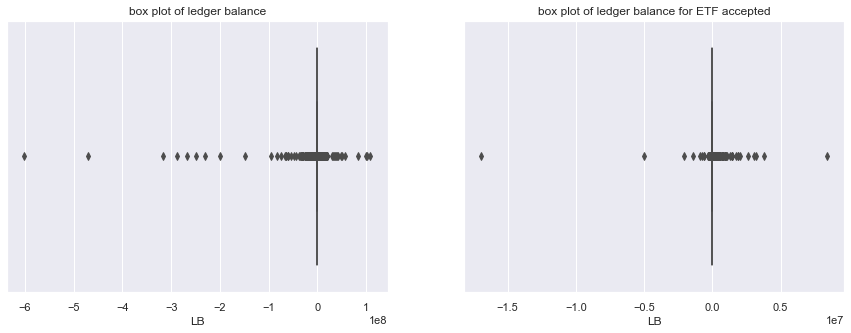

In [63]:
sns.set(rc={'figure.figsize':(15,5)})


ig, axs = plt.subplots(ncols=2)
sns.boxplot(df["LB"], ax=axs[0]).set_title("box plot of ledger balance")
sns.boxplot(df[df["ETF"] == 1]["LB"], ax=axs[1]).set_title("box plot of ledger balance for ETF accepted")

Text(0.5, 1.0, 'Bar plot of ledger balance vs ETF accepted clients')

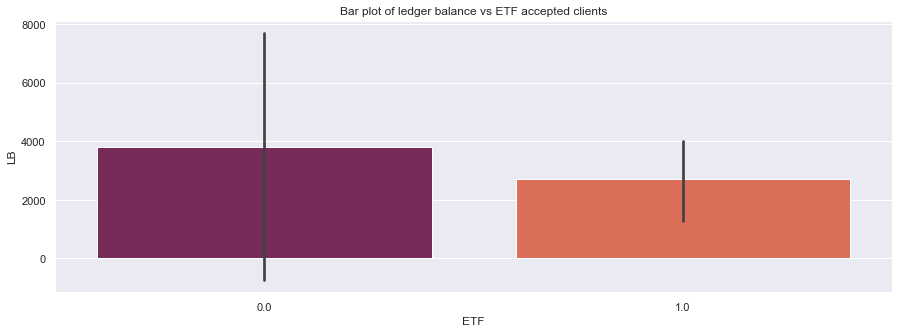

In [64]:
sns.barplot(x = "ETF", y = "LB", data = df, palette = "rocket").set_title("Bar plot of ledger balance vs ETF accepted clients")

The ETFs accpeted by clients within a small range of Ledger balance, so we elimniating the outliers in ledger balance

In [65]:

df =  df[df['LB'].between(df['LB'].quantile(.25), df['LB'].quantile(.75), inclusive=True)]


In [66]:
df.head(3)

cm_cd cm_sex IncomePA   E2Channel  IsKarvy  ETF  cm_age  \
0  51430298      M    5_10L         CAT        0  0.0    21.0   
4  UBMODI74      M     <=1L  Franchisee        0  0.0    47.0   
5  87701530      M    5_10L         CAT        0  0.0    28.0   

   days_since_last_login      LB  online%  Ttweb%  #trades  #TT_logins  \
0                    8.0    0.00      0.0     0.0        0           0   
4                   16.0    0.00      0.0     0.0        0           0   
5                  185.0  195.97      0.0     0.0        1           0   

   #mobile_logins  
0               0  
4               0  
5               1

In [67]:
df["ETF"].value_counts()

0.0    333856
1.0     20558
Name: ETF, dtype: int64

#### Age

In [68]:
sns.set(rc={'figure.figsize':(15,5)})

fig, axs = plt.subplots(ncols=2)
sns.distplot(df["cm_age"], ax=axs[0]).set_title("Distribution plot of age of all clients")
sns.distplot(df[df["ETF"] == 1]["cm_age"], ax=axs[1]).set_title("Distribution plot of client age who accepted ETF")

Text(0.5, 1.0, 'Distribution plot of client age who accepted ETF')

Text(0.5, 1.0, 'Histogram of number of clients accepted ETFs')

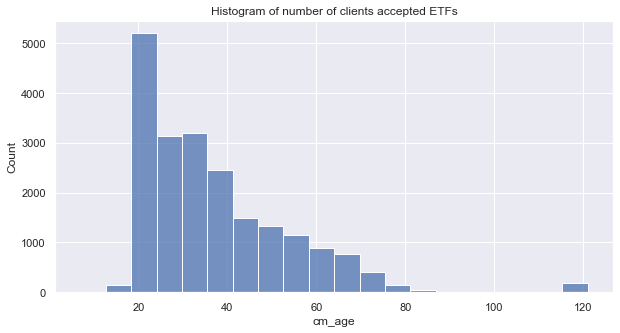

In [69]:
sns.set(rc={'figure.figsize':(10,5)})

sns.histplot(data = df[df["ETF"] == 1], x = "cm_age", bins = 20).set_title("Histogram of number of clients accepted ETFs")

In [70]:
df = df[(df["cm_age"] >= 18) &  (df["cm_age"] <= 80)]

In [71]:
df["ETF"].value_counts()

0.0    331668
1.0     20297
Name: ETF, dtype: int64

#### #mobile_logins

In [72]:
sns.set(rc={'figure.figsize':(15,5)})

fig, axs = plt.subplots(ncols=2)
sns.distplot(df["#mobile_logins"], ax=axs[0]).set_title("Distribution plot of number of mobile logins of clients")
sns.distplot(df[df["ETF"] == 1]["#mobile_logins"], ax=axs[1]).set_title("Distribution plot of number of mobile logins of clients who accepted ETF")

Text(0.5, 1.0, 'Distribution plot of number of mobile logins of clients who accepted ETF')

WE can eliminate the customers with mobole logins more than 3000, as they have not accepted any ETFs in the past

In [73]:
df = df[df["#mobile_logins"] < 3000]

In [74]:
df["ETF"].value_counts(), df.shape

(0.0    330239
 1.0     20296
 Name: ETF, dtype: int64,
 (350535, 14))

In [75]:
df.head()

cm_cd cm_sex IncomePA   E2Channel  IsKarvy  ETF  cm_age  \
0  51430298      M    5_10L         CAT        0  0.0    21.0   
4  UBMODI74      M     <=1L  Franchisee        0  0.0    47.0   
5  87701530      M    5_10L         CAT        0  0.0    28.0   
7  ACHARA11      M    5_10L  Franchisee        0  0.0    33.0   
9  NAVYAS93      F     1_5L      Premia        0  0.0    28.0   

   days_since_last_login      LB  online%  Ttweb%  #trades  #TT_logins  \
0                    8.0    0.00      0.0     0.0        0           0   
4                   16.0    0.00      0.0     0.0        0           0   
5                  185.0  195.97      0.0     0.0        1           0   
7                    3.0    0.00      0.0     0.0        0           0   
9                    4.0   72.33      0.0     0.0        3           3   

   #mobile_logins  
0               0  
4               0  
5               1  
7               0  
9               0

#### #TTlogins

In [76]:
sns.set(rc={'figure.figsize':(15,5)})

# fig, axs = plt.subplots(ncols=2)
# sns.distplot(df["#TT_logins"], ax=axs[0]).set_title("Distribution plot of number of TT logins of clients")
# sns.distplot(df[df["ETF"] == 1]["#TT_logins"], ax=axs[1]).set_title("Distribution plot of number of TT logins of clients who accepted ETF")

WE can eliminate the customers with TT logins more than 2500, as they have not accepted any ETFs in the past

In [77]:
df = df[df["#TT_logins"] < 2500]
df["ETF"].value_counts(), df.shape

(0.0    330122
 1.0     20295
 Name: ETF, dtype: int64,
 (350417, 14))

#### #trades

Text(0.5, 1.0, 'Distribution plot of number of trades of clients who accepted ETF')

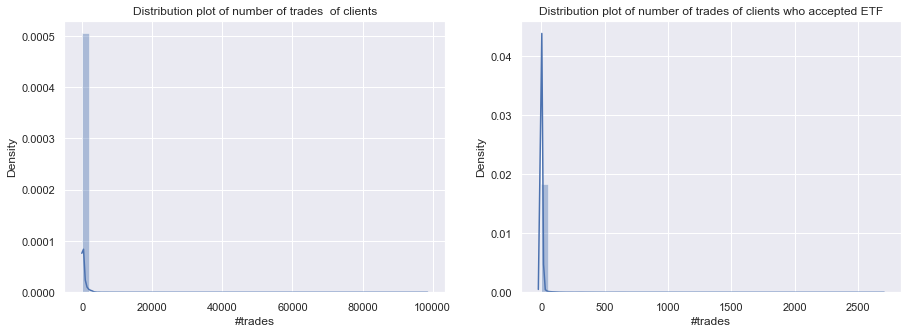

In [78]:
sns.set(rc={'figure.figsize':(15,5)})

fig, axs = plt.subplots(ncols=2)
sns.distplot(df["#trades"], ax=axs[0]).set_title("Distribution plot of number of trades  of clients")
sns.distplot(df[df["ETF"] == 1]["#trades"], ax=axs[1]).set_title("Distribution plot of number of trades of clients who accepted ETF")

WE can eliminate the customers with TT logins more than 5000, as they have not accepted any ETFs in the past

In [79]:
df = df[df["#trades"] < 5000]
df["ETF"].value_counts(), df.shape

(0.0    329886
 1.0     20295
 Name: ETF, dtype: int64,
 (350181, 14))

## Data Visualization

In [80]:
df.head()

cm_cd cm_sex IncomePA   E2Channel  IsKarvy  ETF  cm_age  \
0  51430298      M    5_10L         CAT        0  0.0    21.0   
4  UBMODI74      M     <=1L  Franchisee        0  0.0    47.0   
5  87701530      M    5_10L         CAT        0  0.0    28.0   
7  ACHARA11      M    5_10L  Franchisee        0  0.0    33.0   
9  NAVYAS93      F     1_5L      Premia        0  0.0    28.0   

   days_since_last_login      LB  online%  Ttweb%  #trades  #TT_logins  \
0                    8.0    0.00      0.0     0.0        0           0   
4                   16.0    0.00      0.0     0.0        0           0   
5                  185.0  195.97      0.0     0.0        1           0   
7                    3.0    0.00      0.0     0.0        0           0   
9                    4.0   72.33      0.0     0.0        3           3   

   #mobile_logins  
0               0  
4               0  
5               1  
7               0  
9               0

Text(0.5, 1.0, 'ETF analysis by income slabs')

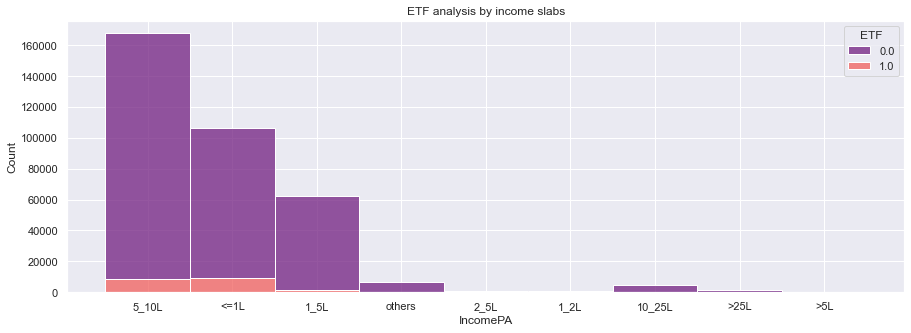

In [81]:
sns.histplot(x = "IncomePA", data = df, hue = "ETF", palette = "magma", multiple = "stack").set_title("ETF analysis by income slabs")

Text(0.5, 1.0, 'ETF analysis by age slabs')

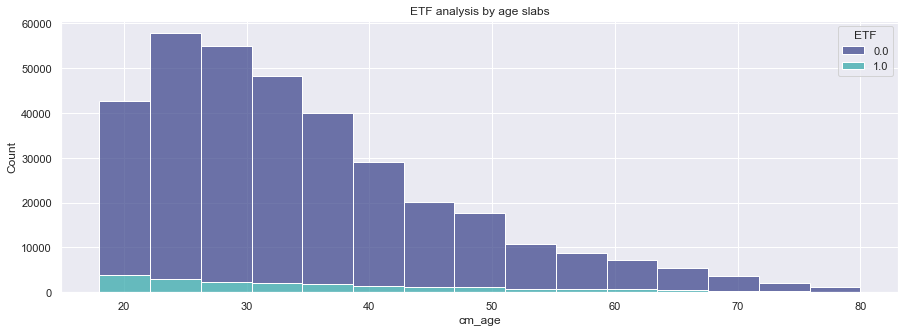

In [82]:
sns.histplot(x = "cm_age", data = df, hue = "ETF", bins = 15, palette = "mako", multiple = "stack").set_title("ETF analysis by age slabs")

In [83]:
sns.histplot(y = "E2Channel", data = df, hue = "ETF", palette = "rocket", multiple = "stack").set_title("ETF analysis by E2channel")

Text(0.5, 1.0, 'ETF analysis by E2channel')

In [84]:
sns.histplot(x = "cm_sex", data = df, hue = "ETF", palette = "rocket", multiple = "stack").set_title("ETF analysis by gender")

Text(0.5, 1.0, 'ETF analysis by gender')

In [85]:
sns.boxplot(x = "ETF", y = "#mobile_logins", data = df).set_title("ETF acceptance trend on number of moble logins")

Text(0.5, 1.0, 'ETF acceptance trend on number of moble logins')

Text(0.5, 1.0, 'Distribution plot of mobile logins for ETF  accepted')

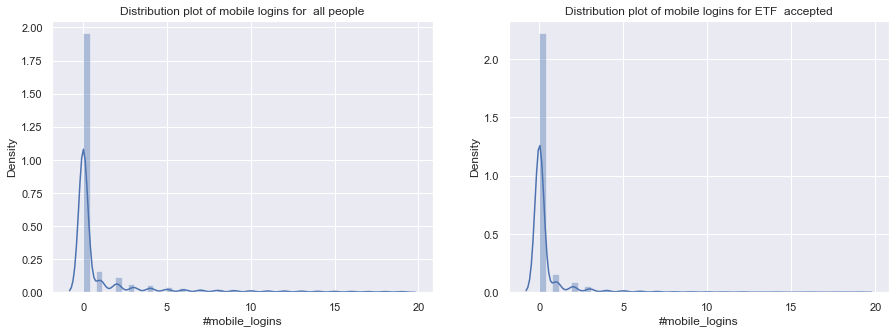

In [86]:
sns.set(rc={'figure.figsize':(15,5)})

fig, axs = plt.subplots(ncols=2)
sns.distplot(df[(df["#mobile_logins"] < 20)]["#mobile_logins"], ax=axs[0]).set_title("Distribution plot of mobile logins for  all people")
sns.distplot(df[(df["ETF"] == 1) & (df["#mobile_logins"] < 20)]["#mobile_logins"], ax=axs[1]).set_title("Distribution plot of mobile logins for ETF  accepted")


Text(0.5, 1.0, 'Histogram plot of online% for ETF  accepted')

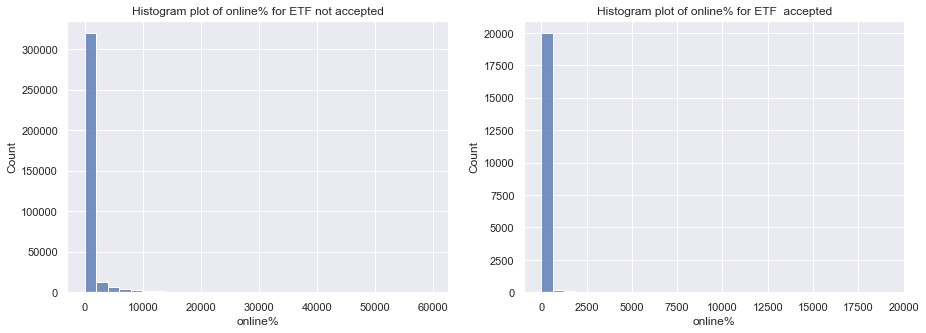

In [87]:
sns.set(rc={'figure.figsize':(15,5)})

fig, axs = plt.subplots(ncols=2)
sns.histplot(df["online%"], ax=axs[0], bins = 30).set_title("Histogram plot of online% for ETF not accepted")
sns.histplot(df[df["ETF"] == 1]["online%"], ax=axs[1], bins = 30).set_title("Histogram plot of online% for ETF  accepted")


In [88]:
print(*df["IncomePA"].value_counts().index)

5_10L <=1L 1_5L others 10_25L >25L 1_2L 2_5L >5L


In [89]:
df_pre = df.copy()


In [90]:
df_pre.to_csv("../results/pre_engineered.csv")

## Feature engineering

In [91]:
def feature_engineering(df):
   
    
    # handing null values(continuos values)
    df["LB"] = df["LB"].fillna(0)
    df["online%"] = df["online%"].fillna(0)
    df["Ttweb%"] = df["Ttweb%"].fillna(0)
    df["#trades"] = df["#trades"].fillna(0)
    df["#TT_logins"] = df["#TT_logins"].fillna(0)
    df["#mobile_logins"] = df["#mobile_logins"].fillna(0)
    df["cm_age"] = df["cm_age"].fillna(df["cm_age"].mean())
    df["days_since_last_login"] = df["days_since_last_login"].fillna(df["days_since_last_login"].mean())
     
    e2_channels = ['CAT', 'Franchisee', 'Premia','GL Investments', 'Banca', 'No Channel', 'Alternate Channel', 'Ho - Support', 'CAL', 'Commodity Direct']
    income_slabs = ['5_10L', '<=1L', '1_5L', '10_25L', '>25L', '1_2L', '2_5L','>5L', '1lakh']
    gender = ["M", "F", "O"]
    # categorical data
    df['E2Channel'].loc[~df['E2Channel'].isin(e2channels)] = 'others'
    df['IncomePA'].loc[~df['IncomePA'].isin(income_slabs)] = 'others'
    df['cm_sex'].loc[~df['cm_sex'].isin(gender)] = 'O'
    df['IsKarvy'] = df['IsKarvy'].fillna(0)
    numerical_cols = ["LB", "online%", "Ttweb%", "#trades", "#mobile_logins", "cm_age", "days_since_last_login"]
   
    df["IncomePA"] = df["IncomePA"].map({"others": 0, "<=1L": 1, "1lakh": 2, "1_2L": 3, "1_5L": 3,"2_5L": 3, ">5L": 4, "5_10L": 4, "10_25L": 5, ">25:": 6})
    df["IncomePA"] = df["IncomePA"].fillna(0)
    # creating dummy for categorical data
    dummy1 = pd.get_dummies(df[["E2Channel", "cm_sex"]], drop_first=True)
    df = pd.concat([df, dummy1], axis=1)
    df = df.drop(["E2Channel", "cm_sex"], axis = 1)
   
   
    # scaling numerical columns
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df


In [92]:
df = df.sample(frac=1)

In [93]:
df = feature_engineering(df)

In [94]:
df.to_csv("../results/post_engineered.csv")

In [95]:
df_presampled = df.copy()
df = df.iloc[:, 1:]# deleting client ids after saving the data sampling 

## Feature engineering

In [96]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

## upsampling the model

In [97]:


not_etf= df[df["ETF"]==0]
etf=df[df["ETF"]==1]

# upsample minority
etf_upsampled = resample(etf,
                          replace=True, # sample with replacement
                          n_samples=len(not_etf), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_etf, etf_upsampled])

# check new class counts
upsampled["ETF"].value_counts()

df = upsampled
df_model = df.copy()

NameError: name 'resample' is not defined

## downsampling the data

In [98]:
from sklearn.utils import resample

not_etf= df[df["ETF"]==0]
etf=df[df["ETF"]==1]
not_etf_downsampled = resample(not_etf,
                                replace = False, # sample without replacement
                                n_samples = len(etf), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_etf_downsampled, etf])

# checking counts
downsampled["ETF"].value_counts()

df = downsampled
df_model = df.copy()

In [99]:
df_model["ETF"].value_counts()


1.0    20295
0.0    20295
Name: ETF, dtype: int64

In [100]:
X = df.drop(["ETF"], axis = 1)
y = df["ETF"]

# X= X.apply(pd.to_numeric, errors='coerce')

#### Checking multicollinearity using VIF score

In [101]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

VIF                    Column
19  7.444636                  cm_sex_M
12  6.835226             E2Channel_CAT
7   6.358877                   #trades
0   5.765622                  IncomePA
9   5.624374            #mobile_logins
13  3.527083      E2Channel_Franchisee
8   3.049009                #TT_logins
6   2.917257                    Ttweb%
5   2.839490                   online%
1   2.097551                   IsKarvy
17  1.880530          E2Channel_Premia
14  1.866165  E2Channel_GL Investments
2   1.472411                    cm_age
4   1.217196                        LB
10  1.143594           E2Channel_Banca
3   1.142667     days_since_last_login
16  1.049208      E2Channel_No Channel
11  1.038400             E2Channel_CAL
18  1.035647          E2Channel_others
15  1.020905    E2Channel_Ho - Support
20  1.006342                  cm_sex_O

We will remove features with VIF more than 6

In [ ]:
X = X.drop(["cm_sex_M"], axis=1)

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

In [102]:
## plotting cumulative variance captured by principal components
from sklearn.decomposition import PCA
sns.set(rc={'figure.figsize':(15,5)})

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Text(0, 0.5, 'cumulative explained variance')

In [103]:
pca = PCA(13)  
print(X.shape)
X = pca.fit_transform(X)
print(X.shape)

(40590, 21)
(40590, 13)


In [104]:
print("Variance captured indivudually by each dimension: {}".format(str(list(np.cumsum(pca.explained_variance_ratio_)))))

Variance captured indivudually by each dimension: [0.995846180813632, 0.9971497147450489, 0.9979766259042167, 0.9985590453733189, 0.9989932582102798, 0.9993531802444074, 0.9995087402220213, 0.9996548293261774, 0.9997320355862094, 0.9998028056729272, 0.9998661367024845, 0.9999135563889613, 0.9999511546419543]


## Model Training

In [105]:

sns.set(rc={'figure.figsize':(10,7)})

sns.heatmap(pd.DataFrame(X).corr()).set_title("Correlation heatmap of traing data")

Text(0.5, 1.0, 'Correlation heatmap of traing data')

In [106]:
X.shape

(40590, 13)

In [107]:
# Logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    ETF   No. Observations:                36531
Model:                            GLM   Df Residuals:                    36517
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19801.
Date:                Mon, 27 Sep 2021   Deviance:                       39603.
Time:                        14:57:50   Pearson chi2:                 2.21e+09
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3468      0.018    -19.285      0.000      -0.382      -0.312
x1            -0.0110      0.001     -8.424      0.000      -0.014      -0.008
x2            -0.2141      0.008    -26.069      0.000      -0.230      -0.198
x3            -1.4505      0.055    -26.575      0.000      -1.558      -1.344
x4            -0.7381      0.020    -37.830      0.000      -0.776      -0.700
x5            -0.7661      0.020    -37.552      0.000      -0.806      -0.726
x6            -0.4772      0.020    -24.000      0.000      -0.516      -0.438
x7            -1.1775      0.057    -20.576      0.000      -1.290      -1.065
x8            -0.3781      0.067     -5.686      0.000      -0.508      -0.248
x9             2.5333      0.124     20.437      0.000       2.290       2.776
x10           -0.4168      0.044     -9.486      0.000      -0.503      -0.331
x11           -0.1096      0.037     -2.974      0.003      -0.182      -0.037
x12            0.9765      0.042     23.140      0.000       0.894       1.059
x13            1.0625      0.053     19.980      0.000       0.958       1.167
==============================================================================
"""

In [108]:
print("Percentage of customers who accepted ETF: {}%".format(str(len(df[df["ETF"] == 1])/len(df)*100)[:6]))

Percentage of customers who accepted ETF: 50.0%


In [109]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE
rfe = RFE(logreg, 13)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [110]:
rfe.support_


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [111]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    ETF   No. Observations:                36531
Model:                            GLM   Df Residuals:                    36517
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19801.
Date:                Mon, 27 Sep 2021   Deviance:                       39603.
Time:                        14:57:53   Pearson chi2:                 2.21e+09
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3468      0.018    -19.285      0.000      -0.382      -0.312
x1            -0.0110      0.001     -8.424      0.000      -0.014      -0.008
x2            -0.2141      0.008    -26.069      0.000      -0.230      -0.198
x3            -1.4505      0.055    -26.575      0.000      -1.558      -1.344
x4            -0.7381      0.020    -37.830      0.000      -0.776      -0.700
x5            -0.7661      0.020    -37.552      0.000      -0.806      -0.726
x6            -0.4772      0.020    -24.000      0.000      -0.516      -0.438
x7            -1.1775      0.057    -20.576      0.000      -1.290      -1.065
x8            -0.3781      0.067     -5.686      0.000      -0.508      -0.248
x9             2.5333      0.124     20.437      0.000       2.290       2.776
x10           -0.4168      0.044     -9.486      0.000      -0.503      -0.331
x11           -0.1096      0.037     -2.974      0.003      -0.182      -0.037
x12            0.9765      0.042     23.140      0.000       0.894       1.059
x13            1.0625      0.053     19.980      0.000       0.958       1.167
==============================================================================
"""

In [112]:
X

array([[-2.39810986, -1.57284185, -0.08856209, ..., -0.13880367,
        -0.10015289,  0.0319023 ],
       [-2.39404502, -0.25584411, -0.27257593, ...,  0.01595745,
         0.12599057,  0.00374671],
       [-2.39599842, -1.60245241,  0.28585242, ..., -0.37164919,
        -0.03094818, -0.69853413],
       ...,
       [-2.39556617,  1.3753613 , -0.49446494, ..., -0.37822435,
        -0.22743476, -0.58276839],
       [-2.39722162,  1.29050498, -0.43573902, ..., -0.14990331,
        -0.33367193,  0.1341549 ],
       [-2.39583494,  2.20392325, -0.13381835, ..., -0.16814132,
         0.06730492, -0.1154822 ]])

In [113]:
X.shape

(40590, 13)

In [114]:
# Getting the predicted values on the train set
y_train_pred = res.predict(sm.add_constant(X_train))
y_train_pred[:10]

array([0.70753376, 0.75766872, 0.73376222, 0.61432326, 0.8050588 ,
       0.77237735, 0.67858305, 0.01231026, 0.39463188, 0.34391618])

In [115]:
train_result = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred, "prospect_ID": y_train.index})

In [116]:
train_result.head(20)

Converted  Converted_prob  prospect_ID
0         1.0        0.707534       862543
1         1.0        0.757669       868598
2         0.0        0.733762       758435
3         0.0        0.614323       910821
4         1.0        0.805059       527727
5         1.0        0.772377       811153
6         0.0        0.678583       226013
7         0.0        0.012310       940366
8         0.0        0.394632       904754
9         1.0        0.343916       637349
10        0.0        0.112069       648452
11        0.0        0.411776       530653
12        0.0        0.030172       833429
13        0.0        0.039348       348557
14        1.0        0.676656       119617
15        0.0        0.024594       822599
16        0.0        0.668325        98734
17        1.0        0.822674       447212
18        0.0        0.055459       531460
19        1.0        0.723487       638069

#### Plotting the ROC curve for train data

In [117]:
import sklearn.metrics as metrics
sns.set(rc={'figure.figsize':(10,7)})

fpr, tpr, threshold = metrics.roc_curve(y_train, y_train_pred)
roc_auc = metrics.auc(fpr, tpr)


plt.title("Receiver Operating Charecteristic for training data")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

In [118]:
X_test_sm = sm.add_constant(X_test)
y_pred = res.predict(X_test_sm)



In [119]:
val_results = pd.DataFrame({"Converted": y_test.values, "Converted_prob": y_pred, "prospect_ID": y_test.index})



In [120]:
val_results.to_csv("val_results.csv")

## Training Results

In [121]:
X.shape

(40590, 13)

In [122]:
plot_train_results = pd.DataFrame({"numbers": [len(X), len(train_result[train_result["Converted"] == 1]), 
                                              len(train_result[(train_result["Converted_prob"] > 0.6)]), 
                                              len(train_result[(train_result["Converted_prob"] > 0.6) &  (train_result["Converted"] == 1)])][::-1]}, 
                                   index = ["Total_train_samples", 
                                           "Actually ETF accepted", 
                                           "Model Predicted Clients", 
                                           "Model Predicted Correctly"][::-1])
    
    
    


In [123]:
plot_train_results

numbers
Model Predicted Correctly    13022
Model Predicted Clients      17074
Actually ETF accepted        18277
Total_train_samples          40590

In [124]:
print("percentage model captured:", plot_train_results.loc["Model Predicted Correctly"][0]/plot_train_results.loc["Model Predicted Clients"][0])

percentage model captured: 0.7626800983952208


Text(0, 0.5, 'Count')

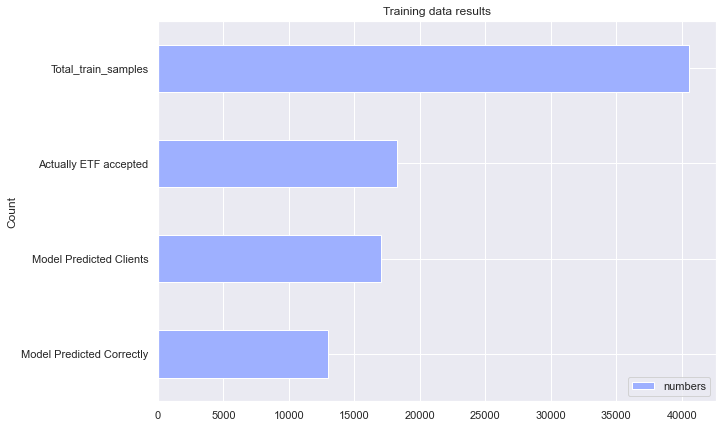

In [125]:
from palettable.scientific.diverging import Berlin_20

plot_train_results.plot(kind = "barh",cmap=Berlin_20.mpl_colormap)
plt.title("Training data results")
plt.ylabel("Count")



## Validation data results

Text(0.5, 0, 'False Positive Rate')

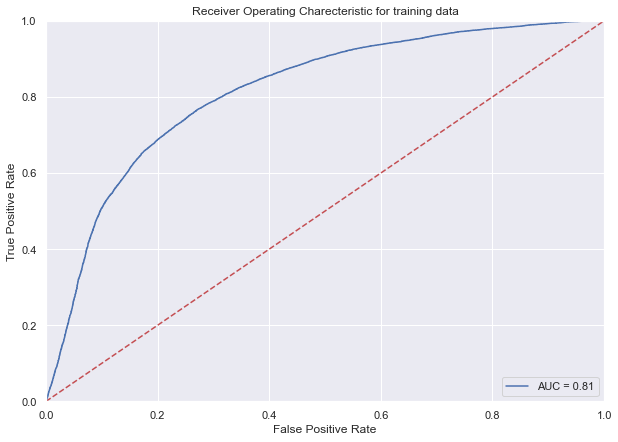

In [126]:
import sklearn.metrics as metrics
sns.set(rc={'figure.figsize':(10,7)})

fpr, tpr, threshold = metrics.roc_curve(y_train, y_train_pred)
roc_auc = metrics.auc(fpr, tpr)


plt.title("Receiver Operating Charecteristic for training data")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'Count')

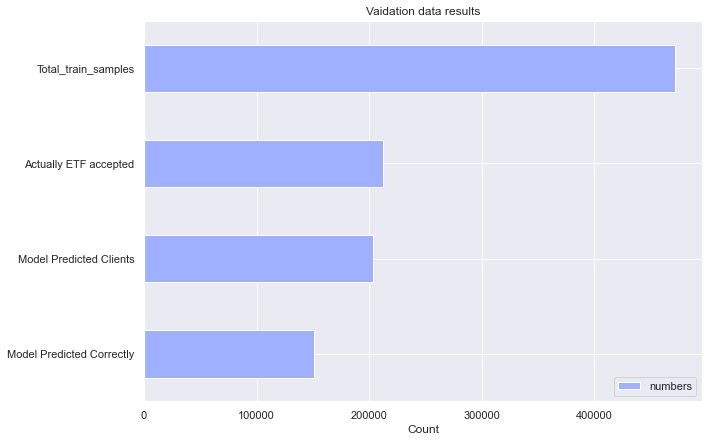

In [179]:
plot_test_results = pd.DataFrame({"numbers": [len(X_test), len(val_results[train_result["Converted"] == 1]), 
                                              len(val_results[(val_results["Converted_prob"] > 0.1)]), 
                                              len(val_results[(val_results["Converted_prob"] > 0.1) &  (val_results["Converted"] == 1)])][::-1]}, 
                                   index = ["Total_test_samples", 
                                           "Actually ETF accepted", 
                                           "Model Predicted Clients", 
                                           "Model Predicted Correctly"][::-1])
    
    
from palettable.scientific.diverging import Berlin_20

plot_train_results.plot(kind = "barh",cmap=Berlin_20.mpl_colormap)
plt.title("Vaidation data results")
plt.xlabel("Count")


    

In [180]:
plot_test_results

numbers
Model Predicted Correctly    23239
Model Predicted Clients      41391
Actually ETF accepted        23613
Total_test_samples           47192

Text(0.5, 0, 'False Positive Rate')

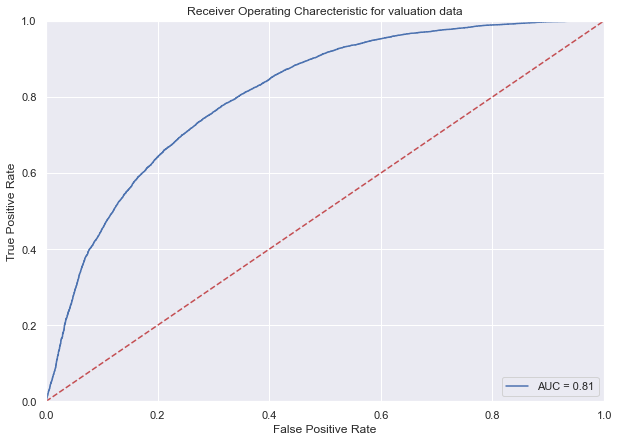

In [181]:
import sklearn.metrics as metrics
sns.set(rc={'figure.figsize':(10,7)})

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)


plt.title("Receiver Operating Charecteristic for valuation data")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [182]:
val_results.to_csv("../data/validation_results.csv")
train_result.to_csv("../data/train_results.csv")

## save model

In [127]:
import joblib
filename = '../model/ETF_propensity_upsampled.sav'
joblib.dump(res, filename)

# loaded_model = joblib.load(filename)

['../model/ETF_propensity_upsampled.sav']

## Getting insights of probable customers


In [ ]:
df["ETF"].value_counts()

In [ ]:
df_high = df_presampled.loc[train_result[(train_result["Converted"] == 0) & (train_result["Converted_prob"] > 0.2)]["prospect_ID"]]


In [ ]:
df_high["ETF"].value_counts()

In [ ]:
df_campaign = df_client[(df_client["E2Channel"] == "CAT") & (df_client["cm_cd"].isin(df_high["cm_cd"]))][["cm_cd", "cm_mobile"]].iloc[:10000, :]

In [ ]:
df_campaign

In [ ]:
df_high["E2Channel"].value_counts()

In [ ]:
df_campaign.to_csv("campaign_data_.csv")

In [ ]:
df_high[["cm_cd"]].to_csv("../data/Probable_ETF.csv")

In [ ]:
chumma = train_result[(train_result["Converted"] == 0) & (train_result["Converted_prob"] > 0.1)]["prospect_ID"]

In [ ]:
df_model.loc[chumma]

In [ ]:
df.loc[[11039]]

In [ ]:
df_temp = df_high[df_high['IncomePA'].notna()][["IncomePA", "ETF"]]
sns.histplot(x = "IncomePA", data = df_temp, hue = "ETF", palette = "magma", multiple = "stack").set_title("ETF analysis by income slabs")

In [ ]:
df_temp = df_high[["cm_age", "ETF"]]
sns.histplot(x = "cm_age", data = df_high, hue = "ETF", bins = 15, palette = "mako", multiple = "stack").set_title("ETF analysis by age slabs")



In [ ]:
df_temp = df_high[df_high['E2Channel'].notna()][["E2Channel", "ETF"]]
e2_channels = ['CAT', 'Franchisee', 'Premia','GL Investments', 'Banca', 'No Channel', 'Alternate Channel', 'Ho - Support', 'CAL', 'Commodity Direct']
    # categorical data
df_temp['E2Channel'].loc[~df_temp['E2Channel'].isin(e2channels)] = 'others'
sns.histplot(y = "E2Channel", data = df_temp, hue = "ETF", palette = "rocket", multiple = "stack").set_title("ETF analysis by E2channel")

In [ ]:
df_high.to_csv("probable_not_accepted_ETF.csv ")

##### fucntion to calculate age

In [17]:
#### Age distribution pof clients
from datetime import datetime
from datetime import date


def calculate_age(born):
    if born == 'nan':
        print("shit")
    age = [] 
    try:
        born = datetime.strptime(born, "%Y%m%d").date()
    except:
        return float("nan")
    today = date.today()
    return today.year - born.year




In [ ]:
##### function to calculate days

In [20]:
def calculate_days(start, end):
    if start == "nan" or end == "nan":
        return float("nan")
    start = pd.to_datetime(start, format='%Y%m%d', errors='ignore')
    end = pd.to_datetime(end, format='%Y%m%d', errors='ignore')
    return (end - start).days

In [ ]:
df_client

## Model Retraining


In [ ]:
df_model =  pd.read_csv("../data/final_preprocessed.csv", index_col=[0])

In [ ]:
xls = pd.ExcelFile('../data/ETF_Campaign_performance_80K_data.xlsx', engine='openpyxl')

# df_upi = pd.read_excel("./Pay_In_Data_1.xlsx", engine='openpyxl', sheetname = "UPI") 

xls.sheet_names




In [ ]:
df_anal = xls.parse(1)
df_anal["Client Id"] = df_anal["Client Id"].astype(str).str.split(".").str[0] 

In [ ]:
df_anal = pd.merge(df_anal, df_model, left_on = "Client Id", right_on = "cm_cd" , how = "inner")[list(df_model.columns)]

In [ ]:
df_model.loc[df_model['cm_cd'].isin(df_anal["cm_cd"]), 'ETF'] = 1

In [ ]:
df_model["ETF"].value_counts()

In [ ]:
sns.histplot(df_anal["cm_age"], bins = 30)


In [ ]:
df_anal

## Daily results

In [ ]:
X = sm.add_constant(X)
y_pred_daily= res.predict(X)


In [ ]:
daily_results = pd.DataFrame({"Converted": y.values, "Converted_prob": y_pred_daily, "prospect_ID": y.index})


In [ ]:
daily_results = daily_results[daily_results["Converted_prob"] >= 0.92]

In [ ]:
daily_results

In [ ]:
plot_daily_results = pd.DataFrame({"numbers": [len(df_model), len(df_model[df_model["ETF"] == 1]), 
                                              len(daily_results[(daily_results["Converted_prob"] > 0.92)]), 
                                              len(daily_results[(daily_results["Converted_prob"] > 0.92) &  (daily_results["Converted"] == 1)])][::-1]}, 
                                   index = ["Total_train_samples", 
                                           "Actually ETF accepted", 
                                           "Model Predicted Clients", 
                                           "Model Predicted Correctly"][::-1])
    
    
    
    

In [ ]:
plot_daily_results

In [ ]:
df_send = df_model.loc[daily_results["prospect_ID"]]

In [ ]:
df_send = df_send[df_send["ETF"] != 1]

In [ ]:
df_send = df_send["cm_cd"]

In [ ]:
df_send.shape

In [ ]:
df_send.to_csv("send_etf_clients.csv")

In [ ]:
df_send

In [ ]:
!pip install graphviz

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Users\C189852\Anaconda3\Lib\site-packages'

In [ ]:
from xgboost import plot_tree
plot_tree(clf)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
df_client

In [ ]:
df_probable = pd.read_csv("send_ETF_clients.csv")

In [ ]:
df_probable =pd.DataFrame(df_probable.rename(columns = {"cm_cd": "client_id"}).iloc[:, 1])

In [ ]:
df_probable = pd.merge(df_probable, df_client, 
                      left_on = "client_id",  right_on = "cm_cd", how = "left")[["client_id", "cm_mobile"]]

NameError: name 'pd' is not defined